In [6]:
import sys
sys.path.append('../../')

from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da,
    utils,
    constants,
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
from scipy import signal
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.graphics.gofplots import qqplot
from scipy import ndimage as ndi
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)
reload(utils)
reload(constants)

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [54]:
np.load('/Users/sean/code/pharynx_redox/data/paired_ratio/warps.npy')

array([[[  2.27272745,   1.12564472,   1.02122066, ...,   1.68214929,
           1.83765849,   1.45207454],
        [  2.63650738,   1.58238413,   1.49564908, ...,   2.09505443,
           2.20090395,   1.86413905],
        [  3.00328264,   2.0406173 ,   1.97118657, ...,   2.51020409,
           2.56867128,   2.27914131],
        ...,
        [ 99.62853168,  99.0918188 ,  99.09330526, ...,  99.35281716,
          99.44468515,  99.29159708],
        [100.23405959,  99.60387398,  99.5908803 , ...,  99.91636252,
         100.03107529,  99.83522417],
        [100.8469026 , 100.1167575 , 100.08815114, ..., 100.48393249,
         100.6232397 , 100.38151109]],

       [[  2.34276757,   1.15927301,   1.03196756, ...,   1.78190328,
           1.63641668,   1.63405505],
        [  2.70484757,   1.60299989,   1.50190576, ...,   2.16631218,
           2.03007075,   2.02877614],
        [  3.06989016,   2.04877583,   1.97325484, ...,   2.55408964,
           2.42708836,   2.42703205],
        ...,


In [102]:
prof_raw = da.load_all_cached_profile_data(Path('/Users/sean/code/pharynx_redox/data/paired_ratio/'), '**/*single_unreg/*.nc')
prof_reg = da.load_all_cached_profile_data(Path('/Users/sean/code/pharynx_redox/data/paired_ratio/'), '**/*matlab_reg/*-trimmed*.nc')
mvmt = da.load_all_movement(Path('/Users/sean/code/pharynx_redox/data/paired_ratio/'))
mvmt = df = da.mvmt_long_to_wide(mvmt)['movement']
rot_fl = xr.load_dataarray('/Users/sean/code/pharynx_redox/data/paired_ratio/all_rot_fl.nc')[:,..., 50:80, 50:120]
warps = np.load('/Users/sean/code/pharynx_redox/data/paired_ratio/warps.npy')

err_raw = da.fold_error(prof_raw)
err_reg = da.fold_error(prof_reg)

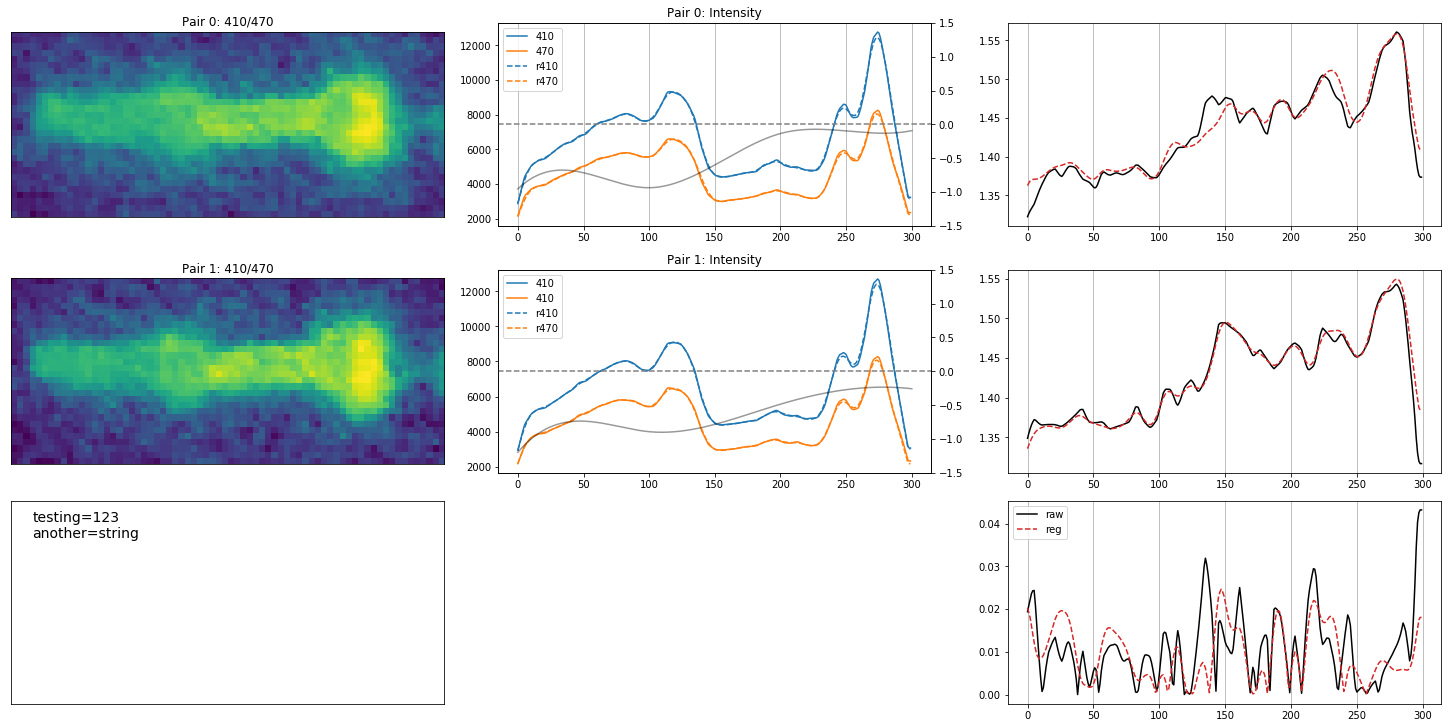

In [130]:
i = i + 1

fig = plt.figure(constrained_layout=True, figsize=(20,10))
gs = GridSpec(3,3, figure=fig)

# COLORS
PAIR_0_COLOR = 'tab:blue'
PAIR_1_COLOR = 'tab:orange'

# PAIR-0 RATIO IMAGE
ax00 = fig.add_subplot(gs[0,0])
ax00.imshow(rot_fl.sel(wavelength='410', pair=0)[i] / rot_fl.sel(wavelength='470', pair=0)[i])
ax00.get_xaxis().set_visible(False)
ax00.get_yaxis().set_visible(False)
ax00.set_title('Pair 0: 410/470')

# PAIR-1 RATIO IMAGE
ax10 = fig.add_subplot(gs[1,0])
ax10.imshow(rot_fl.sel(wavelength='410', pair=1)[i] / rot_fl.sel(wavelength='470', pair=1)[i])
ax10.get_xaxis().set_visible(False)
ax10.get_yaxis().set_visible(False)
ax10.set_title('Pair 1: 410/470')

# INFO BOX
ax20 = fig.add_subplot(gs[2,0])
params = {
    'testing': 123,
    'another': 'string'
}
textstr = '\n'.join('{}={}'.format(k, v) for k, v in params.items())
ax20.text(0.05, 0.95,textstr, transform=ax20.transAxes, fontsize=14,
         verticalalignment='top')
ax20.get_xaxis().set_visible(False)
ax20.get_yaxis().set_visible(False)

# PAIR-0 INTENSITY
ax01 = fig.add_subplot(gs[0,1])
ax01.plot(prof_raw.sel(wavelength='410', pair=0)[i], color='tab:blue', label='410')
ax01.plot(prof_raw.sel(wavelength='470', pair=0)[i], color='tab:orange', label='470')

ax01.plot(prof_reg.sel(wavelength='410', pair=0)[i], color='tab:blue', linestyle='--', label='r410')
ax01.plot(prof_reg.sel(wavelength='470', pair=0)[i], color='tab:orange', linestyle='--', label='r470')

ax01.set_axisbelow(True)
ax01.grid(linestyle='-', linewidth='0.5', color='gray', axis='x')

# ax01.get_xaxis().set_visible(False)
# ax01.get_yaxis().set_visible(False)
ax01.set_title('Pair 0: Intensity')

ax01_twin = ax01.twinx();
ax01_twin.axhline(0, linestyle='--', color='gray');
ax01_twin.plot(np.linspace(0,300,200), np.linspace(0,100,200) - warps[0,:,i], label='warp', color='k', alpha=0.4)
ax01_twin.set_ylim(-1.5, 1.5);



ax01.legend();

# PAIR-1 INTENSITY
ax11 = fig.add_subplot(gs[1,1])
ax11.plot(prof_raw.sel(wavelength='410', pair=1)[i], color='tab:blue', label='410')
ax11.plot(prof_raw.sel(wavelength='470', pair=1)[i], color='tab:orange', label='410')

ax11.plot(prof_reg.sel(wavelength='410', pair=1)[i], color='tab:blue', linestyle='--', label='r410')
ax11.plot(prof_reg.sel(wavelength='470', pair=1)[i], color='tab:orange', linestyle='--', label='r470')

ax01.set_axisbelow(True)
ax01.grid(linestyle='-', linewidth='0.5', color='gray', axis='x')

# ax11.get_xaxis().set_visible(False)
# ax11.get_yaxis().set_visible(False)
ax11.set_title('Pair 1: Intensity')

ax11_twin = ax11.twinx();
ax11_twin.axhline(0, linestyle='--', color='gray');
ax11_twin.plot(np.linspace(0,300,200), np.linspace(0,100,200) - warps[1,:,i], label='warp', color='k', alpha=0.4)
ax11_twin.set_ylim(-1.5, 1.5);

ax11.legend()

# WARP
# ax21 = fig.add_subplot(gs[2,1])
# ax21.plot(np.linspace(0,100,200) - warps[0,:,i], label='pair 0', color=PAIR_0_COLOR)
# ax21.plot(np.linspace(0,100,200) - warps[1,:,i], label='pair 1', color=PAIR_1_COLOR)
# ax21.axhline(0, linestyle='--', color='k');
# ax21.set_ylim(-1, 1);
# ax21.get_xaxis().set_visible(False);
# ax21.legend();
# ax21.set_title('Warp Magnitude')

# PAIR-0 RATIO
ax0_2 = fig.add_subplot(gs[0, 2])

ax0_2.plot(prof_raw.sel(wavelength='r', pair=0)[i], color='k', label='pair 0')
ax0_2.plot(prof_reg.sel(wavelength='r', pair=0)[i], color='tab:red', label='pair 0', linestyle='--')

ax0_2.set_axisbelow(True)
ax0_2.grid(linestyle='-', linewidth='0.5', color='gray', axis='x')

# PAIR-1 RATIO
ax1_2 = fig.add_subplot(gs[1, 2])
ax1_2.plot(prof_raw.sel(wavelength='r', pair=1)[i], color='k', label='pair 1')
ax1_2.plot(prof_reg.sel(wavelength='r', pair=1)[i], color='tab:red', label='pair 1', linestyle='--')

ax1_2.set_axisbelow(True)
ax1_2.grid(linestyle='-', linewidth='0.5', color='gray', axis='x')

# ERROR
ax2_2 = fig.add_subplot(gs[2,2])
ax2_2.plot(err_raw[i], label='raw', color='k')
ax2_2.plot(err_reg[i], linestyle='--', label='reg', color='tab:red')
ax2_2.legend();

ax2_2.set_axisbelow(True)
ax2_2.grid(linestyle='-', linewidth='0.5', color='gray', axis='x')